In [158]:
import re
import ast
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from helpers import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', 50)

## Table of Contents
1. [Data Overview](#section-1)
    1. [Load the data](#section-1.1)
    2. [Is there missing values ?](#section-1.2)
    3. [General statistics](#section-1.3)
    4. [Augmenting the CMU dataset](#section-1.4)
    5. [Cleaning the data](#section-1.5)
    6. [(Optional) Completing the data](#section-1.6)
2. [Exploratory Data Analysis](#section-2)
    2. [Univariate Analysis](#section-2.2)
    3. [Multivariate Analysis](#section-2.3) 
3. [Collaborative filtering Recommandation System](#section-3)
    1. [Load the data](#section-3.1)
    2. [First model](#section-3.2)
4. [Content-based filtering Recommandation System](#section-4)
    1. [First model](#section-4.1)
6. [Hybrid filtering Recommandation System](#section-5)

## 1. Data Overview
<a id='section-1'></a>

### 1.1 Load the data 
<a id='section-1.1'></a>

We first load the data and inspect what information we have in the CMU dataset.

In [106]:
# CMU dataset 
data_folder = './MovieSummaries/MovieSummaries/'

#paths to files
plot_summaries_path = data_folder + 'plot_summaries.txt'
movie_metadata_path = data_folder + 'movie.metadata.tsv'
character_metadata_path = data_folder + 'character.metadata.tsv'

# load the data
# 1. Plot summaries data
df_cmu_plot = pd.read_csv(plot_summaries_path, delimiter='\t', names=['wikipedia_movie_id', 'plot_summary'], encoding='utf-8')

# 2. Movie metadata
df_cmu_movie = pd.read_csv(movie_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 
                                                                            'movie_name', 'release_date', 'box_office_revenue',
                                                                            'runtime', 'languages', 'countries', 'genres'], encoding='utf-8')

# 3. Character metadata
df_cmu_character = pd.read_csv(character_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 
                                                                                    'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                                                                                    'actor_age_at_release', 'freebase_character_actor_map_id', 'freebase_character_id', 
                                                                                    'freebase_actor_id'], encoding='utf-8')

In [107]:
df_cmu_movie.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [108]:
df_cmu_plot.head(2)

,wikipedia_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


In [109]:
df_cmu_character.head(2)

,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [110]:
df_cmu_movie.shape, df_cmu_plot.shape, df_cmu_character.shape

((81741, 9), (42303, 2), (450669, 13))

So for every movie in the dataset we have some information about the movie itself, such as the runtime or the release date (in _df_cmu_movie_), but we also have the plot summary of the film (in _df_cmu_plot_) and different characters in the movie (in _df_cmu_character_) with different information about the actor that played each character. We can directly see that the dataframes don't have the same shape, meaning that we don't have a plot summary for every movie that we have. We can not, for the moment, assess whether we have the characters for every movie based on the given shape as they are an undefined number of characters per movie. As we want to developp a movie recommendation system, we probably won't need all these features and maybe we will need other additional ones, but we will address all of this a little bit later. For the moment, let's check our datasets in more depth.

### 1.2 Is there missing values ?
<a id='section-1.2'></a>

We start by checking if there is any missing values in our datasets.

In [111]:
show_missing_values(df_cmu_movie)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.000000
freebase_movie_id,0,0.000000
movie_name,0,0.000000
release_date,6902,0.084437
box_office_revenue,73340,0.897224
runtime,20450,0.250180
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We can see that the missing proportion for the box office is very high. This might not be a big problem as this is not the most important feature when considering building a movie recommendation system. However, the release date and runtime features will probably be more important, so we will try to find a way to find the missing values.

In [112]:
show_missing_values(df_cmu_plot)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.0
plot_summary,0,0.0


No missing values for the plot summaries, this seems perfect !

In [113]:
show_missing_values(df_cmu_character)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.000000
freebase_movie_id,0,0.000000
release_date,9995,0.022178
character_name,257875,0.572205
actor_dob,106145,0.235528
actor_gender,45609,0.101203
actor_height,295845,0.656457
actor_ethnicity,344611,0.764665
actor_name,1228,0.002725
actor_age_at_release,158113,0.350841


Once again a lot of missing values. However, this is again probably not the most important features to consider when building a recommendation system. For example, we will for sure be interested in knowing the cast of a given movie but not sure that the height of an actor influences whether a film is more liked by a given viewer.

### 1.3 General statistics
<a id='section-1.3'></a>

We now check the type of each of the columns in the different datasets. This allows a quick check of whether a given column has the expected type given the information it has.

In [114]:
print("Dytpes of columns of the different dataframes:\n")
print("------- df_cmu_movie --------")
print(df_cmu_movie.dtypes)
print(29*"-","\n")
print("------- df_cmu_plot --------")
print(df_cmu_plot.dtypes)
print(28*"-","\n")
print("------------ df_cmu_character ------------")
print(df_cmu_character.dtypes)
print(42*"-")

Dytpes of columns of the different dataframes:

------- df_cmu_movie --------
wikipedia_movie_id      int64
freebase_movie_id      object
movie_name             object
release_date           object
box_office_revenue    float64
runtime               float64
languages              object
countries              object
genres                 object
dtype: object
----------------------------- 

------- df_cmu_plot --------
wikipedia_movie_id     int64
plot_summary          object
dtype: object
---------------------------- 

------------ df_cmu_character ------------
wikipedia_movie_id                   int64
freebase_movie_id                   object
release_date                        object
character_name                      object
actor_dob                           object
actor_gender                        object
actor_height                       float64
actor_ethnicity                     object
actor_name                          object
actor_age_at_release               float64
f

We can see that some of the type don't correspond to the expectation such as the release date being a object type. We will take care of this in the cleaning part. 

We now use the describe method as this allows to quickly see the ranges for the numerical columns.

In [115]:
df_cmu_movie.describe()

,wikipedia_movie_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [116]:
df_cmu_character.describe()

,wikipedia_movie_id,actor_height,actor_age_at_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


There seems to have some outliers and/or false informations. Indeed, an height of 510m, an age at release of -7896 or a running time of more than 1e6 minutes are some values that are not possible. Let's have a quick look at an example. 

In [117]:
df_cmu_character[df_cmu_character['actor_height'] == 510].head(3)

,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0


In [118]:
df_cmu_movie[df_cmu_movie['runtime'] == 1.079281e+06]

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


A quick look on [IMdB](https://www.imdb.com/name/nm0004138/) shows that the actor named _Vince Corazza_ is 5'10 which is 1.78m. Once again a quick look on [IMdB](https://www.imdb.com/title/tt0111825/) shows that the film _Zero Tolerance_ was released in 1994 (not a big difference but not quite right) and that the runtime is 88 minutes, which probably makes the film much more enjoyable to watch. We will also take care of all of this in the cleaning part.

As we have seen above, there is a lot of cleaning to do between handling NaNs and outliers as well as keeping only necessary columns. Some columns need their data type to be changed and some columns need a bit of cleaning in the way they store the information such as the languages, genres and countries columns in _df_cmu_movie_. Furthermore, it could be interesting to add some other features that could be useful for a recommendation system such as the director of films as well as completing the lot of missing values that we have. To do that we will use another dataset that will be described just below. Thus, as of now, we will not start cleaning the CMU dataset alone and we will clean only the final merged dataset. This make even more sense considering that we will probably won't be able to keep the same number of movies.

### 1.4 Augmenting the CMU dataset
<a id='section-1.4'></a>

We now import the dataset that we will use to obtain more features as well as completing and correcting the CMU dataset. We quickly perform the same step as above. The dataset has merged information from both a TMdB dataset as well as a Movielens dataset (more information on this in the [Github](https://github.com/epfl-ada/ada-2024-project-skibidata)). The features of the TMdB dataset are going to be used to correct and complete our CMU dataset and the corresponding ratings from multiple users for the different movies will be used a bit later to build one of the recommendation system. For the moment, let's perform the same step as above for the new dataset.

We start by loading the data and checking the first rows.

In [119]:
df_tmdb_movie = pd.read_csv('TMdB_Movielens_combined/movies_metadata.csv', low_memory=False)
df_tmdb_credits = pd.read_csv('TMdB_Movielens_combined/credits.csv')
df_tmdb_keywords = pd.read_csv('TMdB_Movielens_combined/keywords.csv')

In [120]:
df_tmdb_movie.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [121]:
df_tmdb_credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [122]:
df_tmdb_keywords.head(2)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [123]:
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45466, 24), (45476, 3), (46419, 2))

All three dataframes have almost the same number of rows. _df_tmdb_movie_ contains some features about the movies themselves, _df_tmdb_credits_ has the informations about the cast and the crew of each movie. This will be useful to get the director for example as well as having the actors and actresses of each movie more easily. Finally, _df_tmdb_keywords_ contains keywords describing what's happening in the film. This will also be esaier to work with than extracting this from the plot summary feature for example. We start by merging all these dataframes together based on the movies in _df_tmdb_movie_ as we at least want to have the features present in this dataset.

In [124]:
# Drop the duplicates to avoid problems when merging
df_tmdb_movie.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_credits.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_keywords.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45436, 24), (45432, 3), (45432, 2))

In [125]:
# To merge we need to have a common type 
df_tmdb_movie['id'] = pd.to_numeric(df_tmdb_movie['id'], errors='coerce')
df_tmdb_credits['id'] = pd.to_numeric(df_tmdb_credits['id'], errors='coerce')
df_tmdb_keywords['id'] = pd.to_numeric(df_tmdb_keywords['id'], errors='coerce')

In [126]:
df_tmdb_movie.dropna(subset=['id'], inplace=True)
df_tmdb_credits.dropna(subset=['id'], inplace=True)
df_tmdb_keywords.dropna(subset=['id'], inplace=True)

In [127]:
# We have only lost a few movies
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45433, 24), (45432, 3), (45432, 2))

In [128]:
# We start by merging the first two datasets
df_tmp = pd.merge(df_tmdb_movie, df_tmdb_credits, on='id', how='inner')
df_tmp.shape

(45432, 26)

In [129]:
# And then we add the last one
df_tmdb = pd.merge(df_tmp, df_tmdb_keywords, on='id', how='inner')
df_tmdb.shape

(45432, 27)

In [130]:
df_tmdb.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


We now check if there is somme missing values as before.

In [131]:
show_missing_values(df_tmdb)

,Missing Count,Missing Proportion
adult,0,0.000000
belongs_to_collection,40944,0.901215
budget,0,0.000000
genres,0,0.000000
homepage,37658,0.828887
id,0,0.000000
imdb_id,17,0.000374
original_language,11,0.000242
original_title,0,0.000000
overview,954,0.020998


There seems to have a very few number of missing values except for homepage and belongs to collection features. We won't need the homepage feature so that's not a problem. And the belongs to collection feature is built such that a movie that is not part of a franchise is encoded as NaN, so the huge proportion of missing values is probably not a problem. We will need to check the dataset in more depth but for the moment this seems pretty good. Let's now check the type of the columns.

In [132]:
print("Dytpes of columns of the df_tmdb dataframe:\n")
print("-------- df_tmdb_movie ---------")
print(df_tmdb_movie.dtypes)
print(32*"-","\n")

Dytpes of columns of the df_tmdb dataframe:

-------- df_tmdb_movie ---------
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                       float64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object
-------------------------------- 



As before some wrong type to we will need to handle. And now let's check the statistics of numerical columns.

In [133]:
df_tmdb.describe()

,id,revenue,runtime,vote_average,vote_count
count,45432.000000,4.542900e+04,45172.000000,45429.000000,45429.000000
mean,108368.766750,1.121313e+07,94.126384,5.618453,109.938409
std,112472.571213,6.435282e+07,38.413412,1.923980,491.471473
min,2.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,26459.250000,0.000000e+00,85.000000,5.000000,3.000000
50%,59995.500000,0.000000e+00,95.000000,6.000000,10.000000
75%,157350.250000,0.000000e+00,107.000000,6.800000,34.000000
max,469172.000000,2.787965e+09,1256.000000,10.000000,14075.000000


There seems to have less outliers or false information. However, we can typically see that for the revenue we have almost all statistics at 0, meaning that we probably have a revenue of 0 instead of NaN values when the information is either missing or doesn't exist.

We now want to merge the CMU and TMdB datasets. However, in the CMU dataset we have two IDs per film, the wikipedia IDs and the freebase IDs. We also have two IDs in the tmdb dataset but this time it is the TMdB IDs and the IMdB IDs, which is unfortunate. We retrieved IMdB IDs from the movies in our original dataset on [wikipedia](https://www.wikipedia.org/). This allows to have a common ID in both datasets to perform the merges more easily.

### Getting IMdB id for CMU dataset

We queried wikidata using SPARQL to retrieve IMdB IDs and freebase IDs of all movies on wikidata. The freebase IDs will be used to map our movies to the correct IMdB IDs and these will be used to perform the merge. We could retrieve a lot more information on [Wikidata](https://www.wikidata.org/wiki/Wikidata:WikiProject_Movies/Properties) about each movie and correct our dataset. However, this would take us away from having the CMU dataset as our main dataset. So we just retrieve the IDs and then merge the queried datafram with _df_cmu_movie_ before merging again the new dataset with _df_tmdb_.

In [30]:
# This line is commented as the query sometimes crashes (if connection to server fails). We made necessary numbers of query such that the data was 
# obtain once and we saved everything in a csv file to use it more easily.

#wiki_df = wikipedia_query()

Wikipedia query successful
file wiki.csv saved


In [134]:
wiki_df = pd.read_csv('Data/wiki.csv')
wiki_df.head(3)

,imdb_id,freebase_ID
0,tt0498329,/m/05c02tm
1,tt1741542,/m/0h_37h3
2,tt1675434,/m/0hgqwpj


In [135]:
wiki_df.shape

(121493, 2)

In [136]:
df_cmu_movie_with_id = pd.merge(df_cmu_movie, wiki_df, left_on='freebase_movie_id', right_on='freebase_ID', how='inner')

In [137]:
df_cmu_movie_with_id.shape

(73367, 11)

In [138]:
df_cmu_movie_with_id[['wikipedia_movie_id', 'freebase_movie_id', 'imdb_id']].head(2)

,wikipedia_movie_id,freebase_movie_id,imdb_id
0,975900,/m/03vyhn,tt0228333
1,3196793,/m/08yl5d,tt0245916


In [140]:
# Merge df_tmdb and df_cmu_movie together
df_final_dataset = pd.merge(df_cmu_movie_with_id, df_tmdb, on ='imdb_id', how='inner', suffixes=['_cmu', '_tmdb'])

In [141]:
# Add the plot summaries
df_final_dataset = pd.merge(df_final_dataset, df_cmu_plot, on ='wikipedia_movie_id', how='left')

In [142]:
df_final_dataset.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date_cmu,box_office_revenue,runtime_cmu,languages,countries,genres_cmu,imdb_id,freebase_ID,adult,belongs_to_collection,budget,genres_tmdb,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date_tmdb,revenue,runtime_tmdb,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,/m/03vyhn,False,NaN,28000000,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",http://www.theofficialjohncarpenter.com/ghost-...,10016.0,en,Ghosts of Mars,Melanie Ballard (Natasha Henstridge) is a hard...,7.058599,/rBmkaKxRg55zBZr11EGbedFJM0.jpg,"[{'name': 'Screen Gems', 'id': 3287}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-08-24,14010832.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror is the same on any planet.,Ghosts of Mars,False,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...","[{'id': 166686, 'name': 'climbing up a wall'},...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,/m/0285_cd,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,33592.0,en,White of the Eye,Evidence of mutilated housewives points to a s...,3.121105,/4KAEbWStG4lfUpKtyiRHgIuljf3.jpg,"[{'name': ""Mrs. White's Productions"", 'id': 26...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1988-05-20,0.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,White of the Eye,False,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...","[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",A series of murders of rich young women throug...
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",tt0029852,/m/02qc0j7,False,NaN,2000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,43839.0,en,Alexander's Ragtime Band,"Roger Grant, a classical violinist, disappoint...",0.632261,/3vDOpV1D2IfuNYCmcBBIXlV9nUc.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1938-05-24,4000000.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,An American Cavalcade!,Alexander's Ragtime Band,False,4.8,6.0,"[{'cast_id': 15, 'character': 'Alexander - Rog...","[{'credit_id': '571952cfc3a3683e6b000122', 'de...","[{'id': 1691, 'name': 'dance'}, {'id': 167411,...",NaN


In [143]:
df_final_dataset.shape

(27329, 38)

We still have more than 27'000 movies which is more than enough to build different recommendation systems.

### 1.5 Cleaning the full dataset
<a id='section-1.4'></a>

We now have a lot of new features, but some are duplicates and sometimes we have not the same information depending of the source dataset. We will need to take care of all of these to have a nice complete and clean dataset to work with afterwards.

We start by dropping non useful columns as well as organizing the columns such that duplictates columns are side by side.

In [144]:
# Dropping non-necessary ids : we have wikipedia_movie_id, imdb_id, tmdb ids called id. We will only keep imdb_id to work with reviews later 
# and drop the rest of them. We also drop some non useful columns such as homepage or status. 

df_final_dataset.drop(columns=['poster_path', 'wikipedia_movie_id', 'freebase_movie_id', 'freebase_ID', 'homepage', 'id', 'status', 'video'], inplace=True)
df_final_dataset = df_final_dataset[['imdb_id', 'movie_name', 'title', 'original_title', 'box_office_revenue', 'revenue', 'budget',
                                     'release_date_cmu', 'release_date_tmdb', 'runtime_cmu', 'runtime_tmdb', 'genres_cmu', 'genres_tmdb',
                                     'languages', 'original_language', 'spoken_languages', 'countries', 'production_countries', 'production_companies', 
                                     'plot_summary', 'overview', 'tagline', 'keywords', 'popularity', 'vote_average', 'vote_count', 'cast', 'crew',
                                     'adult', 'belongs_to_collection']]
df_final_dataset.shape                      

(27329, 30)

In [145]:
df_final_dataset.head(2)

,imdb_id,movie_name,title,original_title,box_office_revenue,revenue,budget,release_date_cmu,release_date_tmdb,runtime_cmu,runtime_tmdb,genres_cmu,genres_tmdb,languages,original_language,spoken_languages,countries,production_countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,crew,adult,belongs_to_collection
0,tt0228333,Ghosts of Mars,Ghosts of Mars,Ghosts of Mars,14010832.0,14010832.0,28000000,2001-08-24,2001-08-24,98.0,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/09c7w0"": ""United States of America""}","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Screen Gems', 'id': 3287}, {'name':...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[{'id': 166686, 'name': 'climbing up a wall'},...",7.058599,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...",False,NaN
1,tt0094320,White Of The Eye,White of the Eye,White of the Eye,NaN,0.0,0,1987,1988-05-20,110.0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/07ssc"": ""United Kingdom""}","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]","[{'name': ""Mrs. White's Productions"", 'id': 26...",A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",3.121105,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...",False,NaN


We have the followings duplicates: title/movie_name (and original_title in a sense), box_office_revenue/revenue, release_date_cmu/release_date_tmdb, genres_cmu/genres_tmdb, languages/original_language and countries/production_countries. They are other columns that have similar information such as plot_summary/overview but we will keep them for now and concentrate our efforts in cleaning the duplicates.

#### _Cleaning title_

We start by checking if the three columns have missing values. Here there are none. We then show the first elements of each of these columns and we can clearly see that the title column has all the titles in english, the original title column has, as expected, the title in the original language. For the movie name we can see a combination of the two in the sense that the chosen language for the title is not consistent. Thus, in this case, we decide to only keep the title column.

In [146]:
show_missing_values(df_final_dataset[['movie_name', 'title', 'original_title']])

,Missing Count,Missing Proportion
movie_name,0,0.0
title,0,0.0
original_title,0,0.0


In [147]:
df_final_dataset[df_final_dataset['original_title'] != df_final_dataset['title']][['title', 'original_title', 'movie_name']].head(5)

,title,original_title,movie_name
16,Rudo & Cursi,Rudo y Cursi,Rudo y Cursi
18,Innocence,Masumiyet,Innocence
21,The Fiances,I fidanzati,I Fidanzati
24,Chasing Ghosts: Beyond the Arcade,Chasing Ghosts,Chasing Ghosts: Beyond the Arcade
30,Twelve Plus One,12 + 1,The Thirteen Chairs


In [148]:
df_final_dataset.drop(columns=['original_title', 'movie_name'], inplace=True)

#### _Cleaning other duplicates_

For the box office, the runtime and the release date we proceed as follows: if there is two NaNs in the two columns we just don't have the information. If the values in the two columns are equal this is perfect. If we have only one value and thus one NaN, we will obviously keep the only value we have. When the values are different we start to check if the difference is of 5% or less for the runtime and the box office. In this case, we keep the value from the CMU dataset. For the release date, we check if the year is the same and in this case we also choose the value from the CMU dataset. For all the remaining different values, we decide to choose the one from the CMU dataset. One could argue that we could just choose the values of the CMU dataset in all case where the values are different, as this is actually what we do. However, we proceed this way such that we have a better comprehension of our data and this also could be useful if we decide to retrieve informations somewhere, typically on IMdB or Wikipedia for the the remaining cases where the values are not the same.

In [150]:
df_final_dataset['release_date_cmu'] = pd.to_datetime(df_final_dataset['release_date_cmu'], errors='coerce')
df_final_dataset['release_date_tmdb'] = pd.to_datetime(df_final_dataset['release_date_tmdb'], errors='coerce')
# As we have seen above, the revenue column contains 0 when the value is not known or don't exists so we replace them with NaNs
df_final_dataset['revenue'] = df_final_dataset['revenue'].replace(0, np.nan)

In [151]:
show_missing_values(df_final_dataset[['box_office_revenue', 'revenue']])

,Missing Count,Missing Proportion
box_office_revenue,19768,0.723334
revenue,21429,0.784112


In [152]:
show_missing_values(df_final_dataset[['release_date_cmu', 'release_date_tmdb']])

,Missing Count,Missing Proportion
release_date_cmu,10860,0.397380
release_date_tmdb,7,0.000256


In [153]:
show_missing_values(df_final_dataset[['runtime_cmu', 'runtime_tmdb']])

,Missing Count,Missing Proportion
runtime_cmu,1242,0.045446
runtime_tmdb,22,0.000805


In [160]:
df_final_dataset = clean_duplicates(df_final_dataset)
# The output printed in this function will be changed to be more clear (but not for the P2 deliverable)

Creating new columns 'box_office_clean', 'release_date_clean and 'runtime_clean' with NaNs or NaTs
Each of them has respectively 27329, 27329 and 27329 NaN/Nat values
Number of rows where the two columns are NaNs: 18185, 4, 2 respectively

Some examples:
box_office_revenue    NaN
revenue               NaN 

release_date_cmu     NaT
release_date_tmdb    NaT
Name: 1664, dtype: object 

runtime_cmu     NaN
runtime_tmdb    NaN
Name: 5083, dtype: object 

Number of rows where the two columns have the same values: 2527, 9670, 14438 respectively

Some examples:
box_office_revenue    14010832.0
revenue               14010832.0
Name: 0, dtype: object 

release_date_cmu     2001-08-24 00:00:00
release_date_tmdb    2001-08-24 00:00:00
Name: 0, dtype: object 

runtime_cmu     98.0
runtime_tmdb    98.0
Name: 0, dtype: object 

Updating values in the new columns...
Done

Each of the column has now respectively 24802, 17659 and 12891 NaN/Nat values

Number of rows where the two columns have only one 

In [161]:
show_missing_values(df_final_dataset[['box_office_clean', 'release_date_clean', 'runtime_clean']])

,Missing Count,Missing Proportion
box_office_clean,10825,0.396099
release_date_clean,10863,0.397490
runtime_clean,12891,0.471697


We can see that the proportion of missing values for the box office is way lower than before. And not all movies were released at the cinema, so we can not expect to have zero missing count. However, for the release date with have the same proportion and for the runtime it is worse than before. This is a strange behaviour, the function will be checked again soon in order to find any mistakes and/or understand what is happening.

In [162]:
df_final_dataset.drop(columns=['box_office_revenue', 'revenue', 'release_date_cmu', 'release_date_tmdb', 'runtime_cmu', 'runtime_tmdb'], inplace=True)
df_final_dataset.shape

(27329, 25)

We still have some duplicates. However, this is for columns of the CMU dataset that don't have any missing values as shown below, thus we will keep the original column and drop the one from the TMdB dataset. 

In [163]:
show_missing_values(df_final_dataset[['genres_cmu', 'languages', 'countries']])

,Missing Count,Missing Proportion
genres_cmu,0,0.0
languages,0,0.0
countries,0,0.0


In [164]:
df_final_dataset.drop(columns=['genres_tmdb', 'production_countries'], inplace=True)

#### _Cleaning everything else_

In [165]:
df_final_dataset.head(2)

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,crew,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean
0,tt0228333,Ghosts of Mars,28000000,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/09c7w0"": ""United States of America""}","[{'name': 'Screen Gems', 'id': 3287}, {'name':...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[{'id': 166686, 'name': 'climbing up a wall'},...",7.058599,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...",False,NaN,14010832.0,2001-08-24,98.0
1,tt0094320,White of the Eye,0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/07ssc"": ""United Kingdom""}","[{'name': ""Mrs. White's Productions"", 'id': 26...",A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",3.121105,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...",False,NaN,NaN,NaT,110.0


In [166]:
df_final_dataset.shape

(27329, 23)

We now clean the remaining columns such as extracting the information from the dictionnary in each row

In [167]:
df_final_dataset['countries'] = df_final_dataset['countries'].apply(extract_from_dict)
df_final_dataset['languages'] = df_final_dataset['languages'].apply(extract_from_dict)
df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].apply(extract_from_dict)
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].fillna('[]')# Apply literal_eval only to entries that are strings
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else np.nan
)

# Count the number of languages if the entry is a list; otherwise, assign NaN
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].apply(
    lambda x: len(x) if isinstance(x, list) else np.nan
)

df_final_dataset['cast'] = df_final_dataset['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_dataset['cast'] = df_final_dataset['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) and all(isinstance(i, dict) and 'name' in i for i in x) else [])

df_final_dataset['crew'] = df_final_dataset['crew'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_dataset['crew'] = df_final_dataset['crew'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) and all(isinstance(i, dict) and 'name' in i for i in x) else [])

df_final_dataset['keywords'] = df_final_dataset['keywords'].apply(ast.literal_eval)
df_final_dataset['keywords'] = df_final_dataset['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df_final_dataset['production_companies'] = df_final_dataset['production_companies'].fillna('[]').apply(ast.literal_eval)
df_final_dataset['production_companies'] = df_final_dataset['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

We then extract the director from the crew column. We then drop this column as we will not use any other information from it. 

In [168]:
df_final_dataset['director'] = df_final_dataset['crew'].apply(get_director)

In [169]:
df_final_dataset.drop(columns=['crew'], inplace=True)

In [170]:
df_final_dataset.head(2)

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean,director
0,tt0228333,Ghosts of Mars,28000000,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,en,1,United States of America,"[Screen Gems, Storm King Productions, Animatio...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[climbing up a wall, hung upside down, flashba...",7.058599,4.8,299.0,"[Natasha Henstridge, Ice Cube, Jason Statham, ...",False,NaN,14010832.0,2001-08-24,98.0,NaN
1,tt0094320,White of the Eye,0,"Thriller, Erotic thriller, Psychological thriller",English Language,en,1,United Kingdom,[Mrs. White's Productions],A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[arizona, suspense, series of murders]",3.121105,5.7,15.0,"[David Keith, Cathy Moriarty, Alan Rosenberg, ...",False,NaN,NaN,NaT,110.0,NaN


We thus have our final dataset concerning the movies and their features.

### 1.6 (Optional) Completing the data
<a id='section-1.6'></a>

In [171]:
# use cinemagoer to complete even more the dataset

## 2. Exploratory Data Analysis
<a id='section-2'></a>

We can finally proceed to some exploratory data analysis. We start by exploring some columns by themselves before exploring some links between them.

### 2.1 Univariate Analysis
<a id='section-2.1'></a>

#### _Countries of production_

We start by having a look at the number of movies produced in each country.

In [61]:
# Split when there is more than one country by movie
df_countries = df_final_dataset['countries'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
df_countries

0        United States of America
1                  United Kingdom
2        United States of America
3                  United Kingdom
4        United States of America
                   ...           
27325              United Kingdom
27326                      Russia
27327                      Russia
27328                     Ireland
27328              United Kingdom
Length: 35016, dtype: object

In [62]:
# And then count them
country_counts_df = df_countries.value_counts().reset_index(name='count').rename(columns={'index': 'country'})
country_counts_df.head(3)

,country,count
0,United States of America,16570
1,United Kingdom,3337
2,France,2508


We use Geopandas library in order to plot the number of movies per film on a world map. To do so, one needs to download the countries "shape" on [Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/) (Download countries (210.08 KB) version 5.1.1). We can then merge our dataset with the countries in the downloaded file. Note that some country won't be merged such as German Democratic Republic, Ukrainian SSR or Palestinian Territories. Either because the country doesn't exit anymore or for unknown reason to us. However, we are good for most of our countries.

In [173]:
world = gpd.read_file(f"Data/ne_110m_admin_0_countries.shp")
names = ['German Democratic Republic', 'Ukrainian SSR', 'Palestinian Territories']
result = pd.Series(names).isin(world['NAME'])
result

0    False
1    False
2    False
dtype: bool

In [174]:
merged = world.merge(country_counts_df, left_on='NAME', right_on='country', how='left')

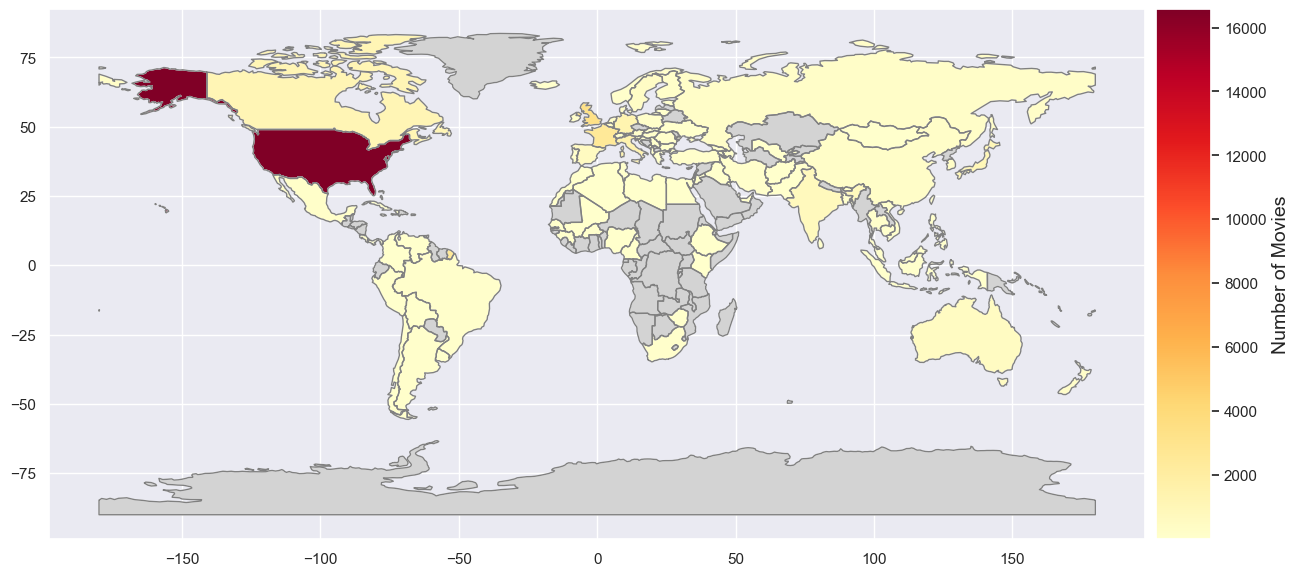

In [175]:
create_world_map(merged, 'count', world)

We can see that a vast majority of the movies are produced in the United States of America, as expected. Since the gap is quite big, we also plot the sampe map but with the logarithm of the numbers of movies by country. This allows a better view of the differences but is not very practical to compare the number of movies.

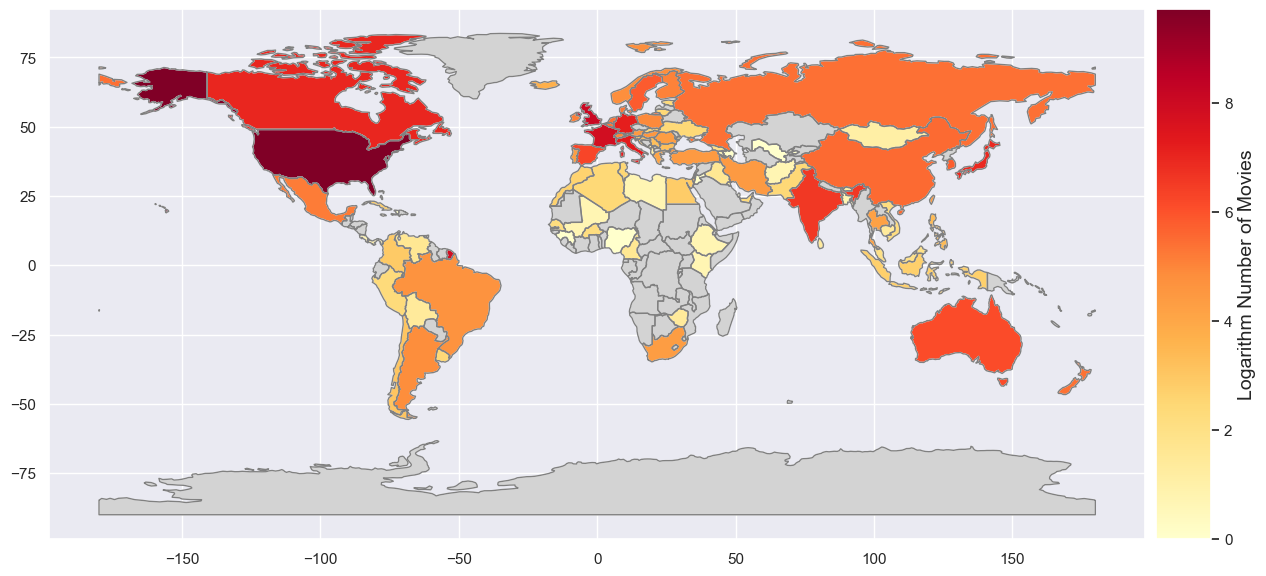

In [176]:
merged['log_count'] = np.log(merged['count'])
create_world_map(merged, 'log_count', world, log=True)

These results are probably expected by most people: India is sproducing also a lot of movies. Canada and Europe are also producing a lot of movies. Overall, we can see that we have data about movies from a lot of diverse countries. 

#### _Runtime_

We now perform some initial analysis on the running time.

In [177]:
df_runtime = pd.DataFrame(df_final_dataset['runtime_clean'])

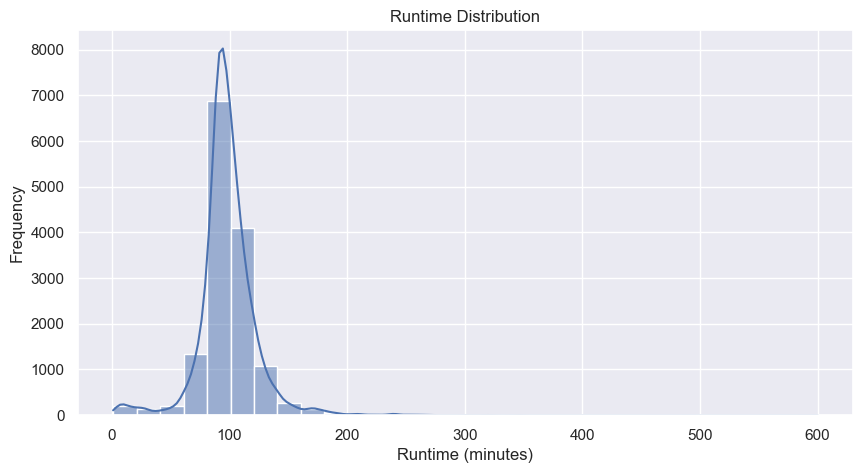

In [180]:
plt.figure(figsize=(10, 5))
sns.histplot(df_runtime.dropna(), bins=30, kde=True, legend=False)
plt.title('Runtime Distribution')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

While this is not completely obvious on the above graph we have a minimum for the runtime at 1 minute up to 600 minutes for the maximum as shown below with the describe method.

In [182]:
df_runtime.describe()

,runtime_clean
count,14438.000000
mean,98.223784
std,25.490286
min,1.000000
25%,88.000000
50%,96.000000
75%,108.000000
max,600.000000


In [183]:
df_final_dataset[df_runtime['runtime_clean'] == 600]

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean,director
5420,tt0220924,New York: A Documentary Film,0,"History, Documentary",English Language,en,0,United States of America,[],NaN,Ric Burns (brother of the famed documentarian ...,NaN,[],0.316897,9.0,1.0,[David Ogden Stiers],False,NaN,NaN,1999-11-14,600.0,NaN


One might think that this is again a wrong information. However, a look on [Wikipedia](https://en.wikipedia.org/wiki/New_York:_A_Documentary_Film), shows that this "movie" is documentary movie in many parts, which explains the very long runtime. Sometimes we get the impression that films are getting longer and longer. Is this really the case? 

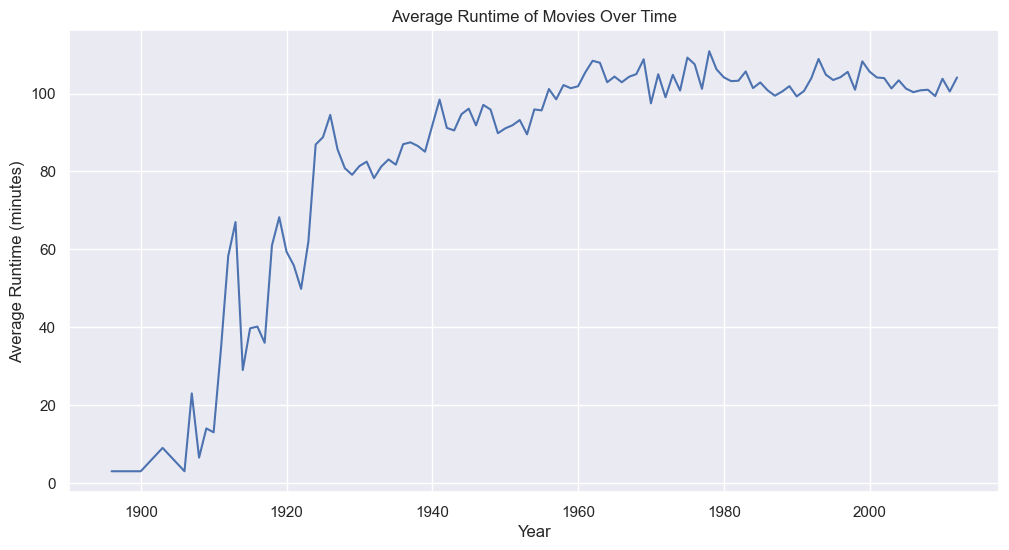

In [185]:
runtime_over_time = df_final_dataset.groupby(df_final_dataset['release_date_clean'].dt.year)['runtime_clean'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=runtime_over_time.index, y=runtime_over_time.values)
plt.title('Average Runtime of Movies Over Time')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.show()

This doesn't seem to be the case. However we don't have much movie after 2010 and only a subset of all movies that are released each year, so we can not really conlude anything.

#### _Box office_

Let's now check the distribution of the box office.

In [186]:
df_box_office = pd.DataFrame(df_final_dataset['box_office_clean'])

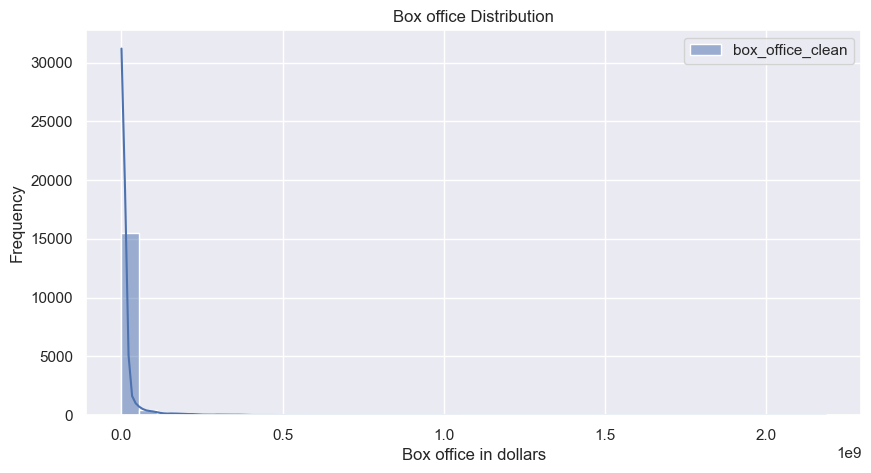

In [187]:
plt.figure(figsize=(10, 5))
sns.histplot(df_box_office.dropna(), bins=40, kde=True)
plt.title('Box office Distribution')
plt.xlabel('Box office in dollars')
plt.ylabel('Frequency')
plt.show()

The above graph is not very useful as we a lot of movies with very small values of box office and, at the same time, some movies with an huge box office. So let's check the range with the describe method.

In [188]:
df_box_office.describe()

,box_office_clean
count,1.650400e+04
mean,1.453155e+07
std,6.915407e+07
min,0.000000e+00
25%,9.300000e+01
50%,1.090000e+02
75%,8.690430e+05
max,2.185372e+09


As we can see, movies having a box office bigger than a billion dollars are really exceptions.

#### _Language of the movies_

What about the language of the movies ?

In [189]:
df_languages = df_final_dataset['languages'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
df_languages

0        English Language
1        English Language
2        English Language
3        English Language
4        English Language
               ...       
27325    English Language
27326    Russian Language
27327    Russian Language
27327    English Language
27328    English Language
Length: 32446, dtype: object

In [190]:
language_counts_df = df_languages.value_counts().reset_index(name='count').rename(columns={'index': 'language'})
language_counts_df

,language,count
0,English Language,19414
1,French Language,2020
2,Italian Language,1164
3,Spanish Language,1099
4,Japanese Language,973
...,...,...
190,Fulfulde,1
191,Adamawa Language,1
192,Tzotzil language,1
193,Nahuatl languages,1


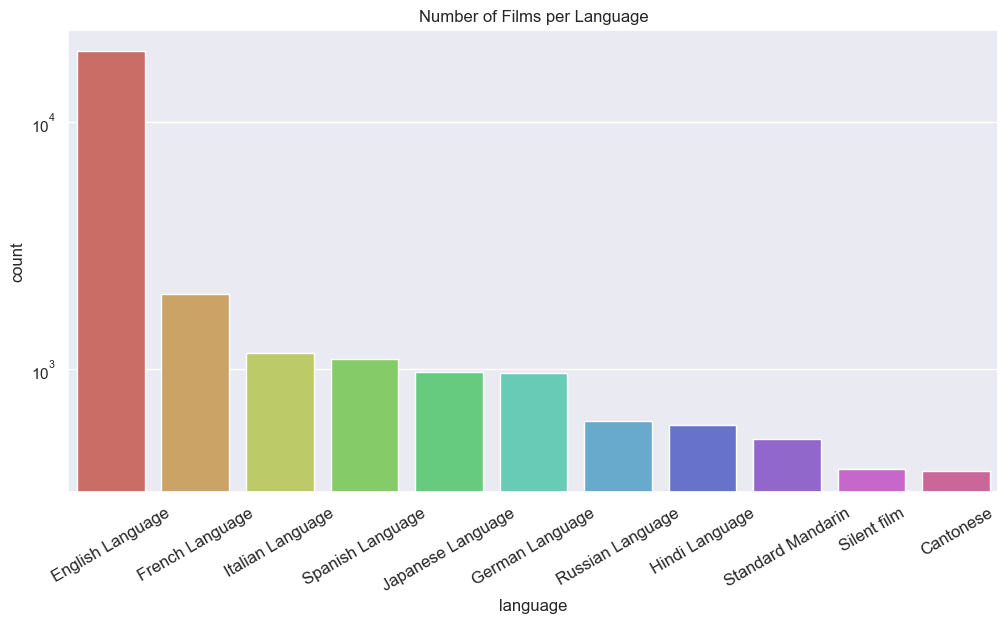

In [191]:
# Assuming you have the 'language_counts_df' DataFrame
colors = sns.color_palette("hls", len(language_counts_df.loc[:10]))

plt.figure(figsize=(12, 6))
sns.barplot(x='language', y='count', data=language_counts_df.loc[:10], 
           palette=colors, hue='language', legend=False)
plt.title('Number of Films per Language')
plt.xticks(rotation=30, fontsize=12)
plt.yscale('log')
plt.show()

As expected, a large number of movies are in english, followed by the french. This aligns more or less with the production countries map shown above even though some major producing countries does not seem to be reflected here.

#### _Release Date_

The release date is often deterministic in the success of a movie,let's check if any trends emerge.

In [193]:
df_final_dataset['release_date_clean'] = pd.to_datetime(df_final_dataset['release_date_clean'], errors='coerce')
df_final_dataset['day'] = df_final_dataset['release_date_clean'].dt.day
df_final_dataset['day'] = df_final_dataset['day'].fillna(0).astype(int)
df_final_dataset['month'] = df_final_dataset['release_date_clean'].dt.month
df_final_dataset['month'] = df_final_dataset['month'].fillna(0).astype(int)
df_final_dataset['year'] = df_final_dataset['release_date_clean'].dt.year
df_final_dataset['year'] = df_final_dataset['year'].fillna(0).astype(int)

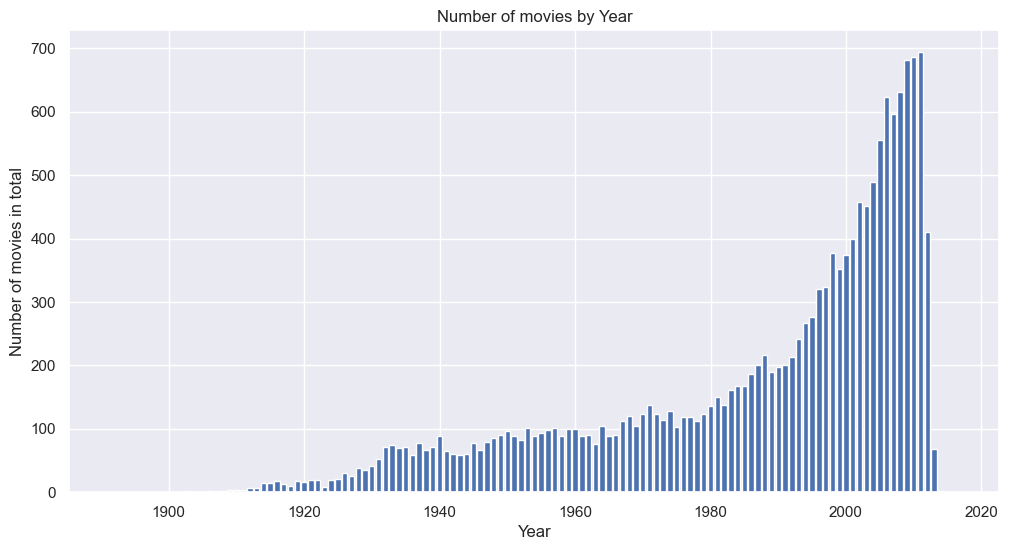

In [194]:
year_occurrences = df_final_dataset['release_date_clean'].dt.year.value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(year_occurrences.index, year_occurrences.values)
plt.xlabel('Year')
plt.ylabel('Number of movies in total')
plt.title('Number of movies by Year')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

As expected, we have more and more movies as the years increase. This is not the case for more recent years, but this is due to the dataset no longer being completed after a certain date. 

In [195]:
month_counts = df_final_dataset[df_final_dataset['month'].between(1, 12)]['month'].value_counts().sort_index()
month_mean = df_final_dataset[(df_final_dataset['box_office_clean'] > 1e8) & (df_final_dataset['month'].between(1, 12))] \
                               .groupby('month')['box_office_clean'].mean()
df_months_and_counts = pd.DataFrame({'month': month_counts.index, 'count': month_counts.values, 'box_office': month_mean.values})

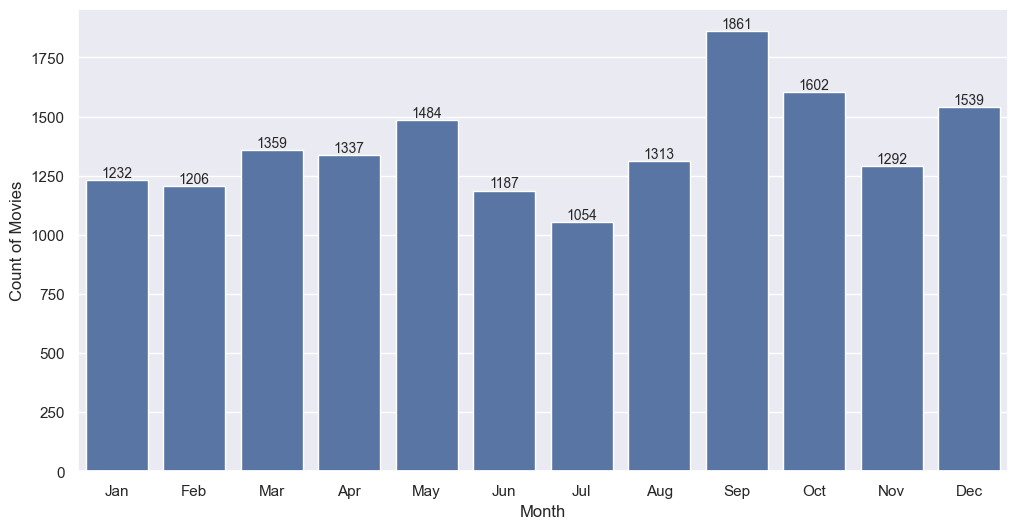

In [196]:
colors = sns.color_palette("husl", len(df_months_and_counts))

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_months_and_counts,
    x='month', 
    y='count',  # Use the colors list here
)

ax.bar_label(ax.containers[0], fontsize=10)

# Set plot title and labels
plt.xlabel("Month")
plt.ylabel("Count of Movies")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Show the plot
plt.show()

The number of movies released by month seems to be more or less the same exceptfor September. 

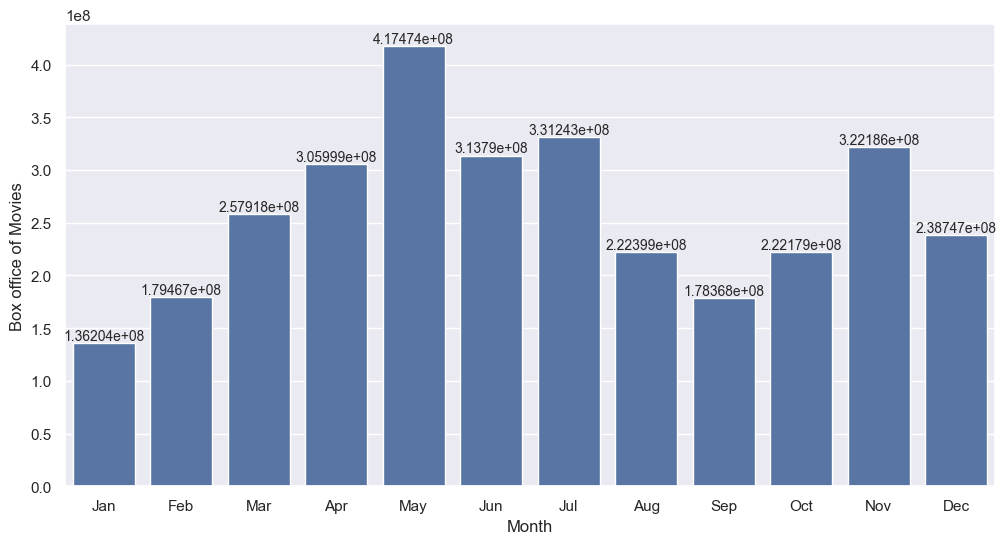

In [197]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_months_and_counts,
    x='month', 
    y='box_office',  # Use the colors list here
)

ax.bar_label(ax.containers[0], fontsize=10)

# Set plot title and labels
plt.xlabel("Month")
plt.ylabel("Box office of Movies")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Show the plot
plt.show()

However, the box office seems to be bigger for May and June but the differences are not big.

In [ ]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

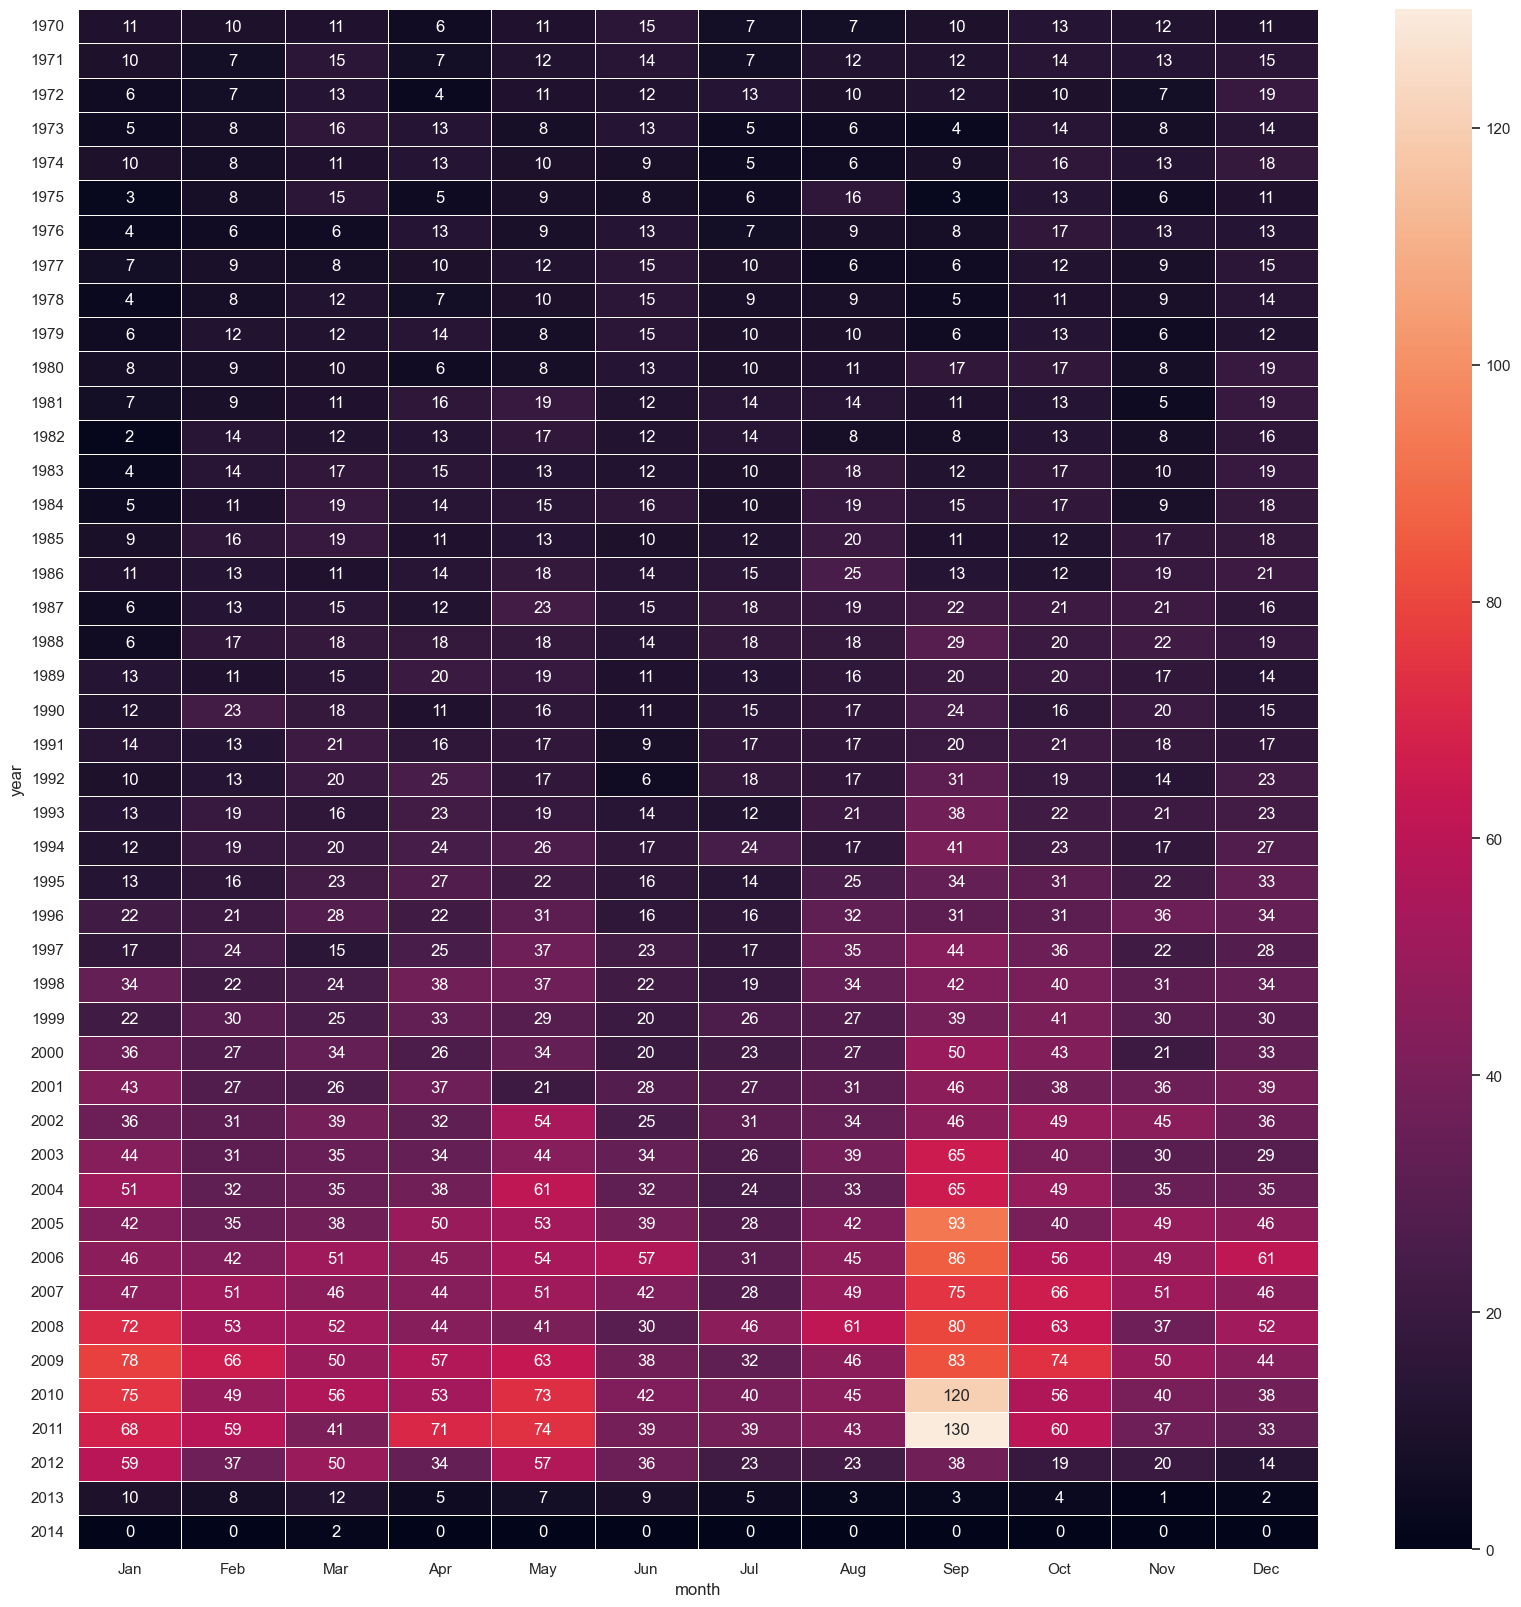

In [198]:
# Create the pivot table with months as columns and years as rows
df_tmp = df_final_dataset[(df_final_dataset['year'] >=1970) & (df_final_dataset['year'] <=2014) ]
hmap = pd.pivot_table(data=df_tmp, index='year', columns='month', aggfunc='count', values='title')
hmap = hmap.fillna(0)

sns.set(font_scale=1)

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='g', xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.yticks(rotation=0)
plt.show()

Just some visualisation that summarizes the number of releases over months and years. No particular tendances seem to emerge apart from the number of movies increasing.

#### _Correlation between the features_

In [ ]:
df_corr = df_final_dataset[['day', 'month', 'year', 'box_office_clean', 'runtime_clean', 'popularity', 'vote_average', 'vote_count']]

,day,month,year,box_office_clean,runtime_clean,popularity,vote_average,vote_count
0,0,0,0,NaN,NaN,7.058599,4.8,299.0
1,0,0,0,NaN,NaN,3.121105,5.7,15.0
2,0,0,0,NaN,NaN,0.632261,4.8,6.0
3,0,0,0,NaN,NaN,1.514972,6.5,34.0
4,0,0,0,NaN,NaN,0.036814,6.0,1.0
...,...,...,...,...,...,...,...,...
27324,0,0,0,NaN,NaN,0.036471,5.0,1.0
27325,0,0,0,NaN,NaN,0.431908,6.0,9.0
27326,0,0,0,NaN,NaN,0.921068,6.6,8.0
27327,0,0,0,NaN,NaN,0.471086,5.6,5.0


### 2.2 Multivariate Analysis
<a id='section-2.2'></a>

NOTE : This section still needs to be extended and should not be considerate as presenting final results

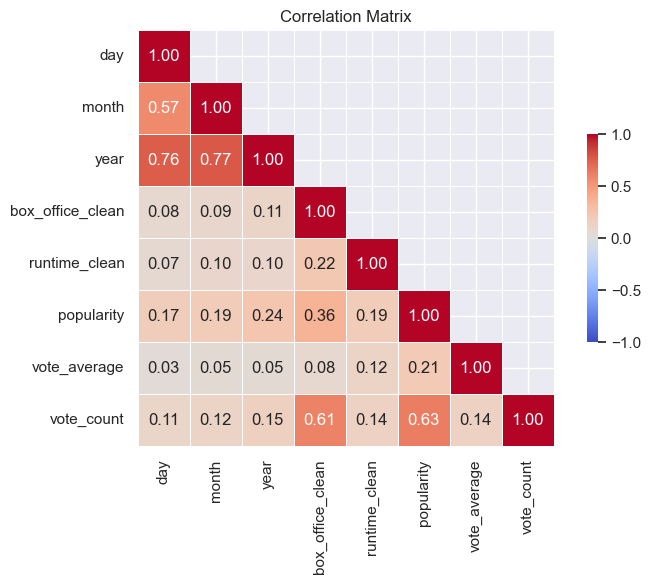

In [199]:
correlation_matrix = df_corr.corr()

mask = np.triu(np.ones_like(correlation_matrix), k=1)

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, 
            annot=True,  
            cmap='coolwarm',  
            center=0,  
            vmin=-1, vmax=1, 
            mask=mask, 
            fmt='.2f', 
            square=True,  
            linewidths=0.5,  
            cbar_kws={'shrink': .5})  

plt.title('Correlation Matrix')
plt.tight_layout()

NOTE : the following sections were just merged before the deliverable. So all the functions are not in the helpers for the moment and the notebook itself is not very clean. Furthermore, the recommendation systems were built on a the same dataset that we used to get the ratings (Movielens) but not on the same subset of movies as we worked on parallel. For the P3 deliverable, everything will, of course, be cleaned and use the correct dataset

## 3. Collaborative filtering Recommandation System
<a id='section-3'></a>

### 3.1 Load the data
<a id='section-3.1'></a>

We start by loading the ratings and take only the movies present in the _df_final_dataset_.

In [200]:
df_ratings = pd.read_csv('TMdB_Movielens_combined/ratings.csv')
df_links = pd.read_csv('TMdB_Movielens_combined/links.csv')

In [201]:
df_links.shape

(45843, 3)

In [202]:
df_ratings.shape

(26024289, 4)

In [204]:
df_final_dataset.shape

(27329, 26)

In [205]:
df_final_dataset['imdb_id'] = df_final_dataset['imdb_id'].str.replace("tt", "").astype(int)

In [206]:
df_ratings_with_imdb_id = pd.merge(df_ratings, df_links, on='movieId', how='left')

In [207]:
df_ratings_with_imdb_id.shape

(26024289, 6)

In [208]:
df_ratings_with_imdb_id.head(2)

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,110,1.0,1425941529,112573,197.0
1,1,147,4.5,1425942435,112461,10474.0


In [209]:
df_ratings_with_imdb_id = df_ratings_with_imdb_id[df_ratings_with_imdb_id['imdbId'].isin(df_final_dataset['imdb_id'].unique())]

In [210]:
df_ratings_with_imdb_id.head(2)

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,110,1.0,1425941529,112573,197.0
1,1,147,4.5,1425942435,112461,10474.0


### 3.2 First model
<a id='section-3.2'></a>

This recommandation model works by using the ratings from the ml-32 dataset to define a huge hyperspace where the rating of each movie is a dimension. The ratings of a specific user are then interpreted as points in this hyperspace.<br>
Next, to obtain movie recommendations for a given user, its n nearest neighbors in this hyperspace are found and the ratings of these users are used to define a weighted average rating of movies seen by this group of users. The system then recommands the movies which have the highest scores and haven't been seen by the subject user.

In [213]:
data_folder = './MovieSummaries/MovieSummaries/'
#paths to files
movie_metadata_path = data_folder + 'movie.metadata.tsv'

# load the data
movie_metadata_df = pd.read_csv(movie_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 
                                                                            'movie_name', 'release_date', 'box_office_revenue',
                                                                            'runtime', 'languages', 'countries', 'genres'], 
                                 encoding='utf-8')

# Ratings data
df = pd.read_csv('./ml-32m/ratings.csv')

# Movie data that will be used to merge the movies from the ratings data and the movies from movie_metadata_df
movies = pd.read_csv('ml-32m/movies.csv')

In [214]:
# Formatting the movie names in the two database such that they can latter be merged on the names
movie_metadata_df['movie_name_formatted'] = movie_metadata_df['movie_name'].str.lower().str.strip()
movies['title_format'] = movies['title'].str[:-6].str.strip().str.lower()

In [215]:
# calculate the number of common movies between the two datasets
common_movies = set(movie_metadata_df['movie_name_formatted']).intersection(set(movies['title_format']))
print('Number of common movies:', len(common_movies))

# merge the two datasets
merged_df = pd.merge(movies, movie_metadata_df, left_on='title_format', right_on='movie_name_formatted', how='inner')

Number of common movies: 25632


In [216]:
# Only take common movies for analysis
movieId_to_keep= set(merged_df[merged_df['movie_name_formatted'].isin(common_movies)]['movieId'])
df_reduced= df[df['movieId'].isin(movieId_to_keep)]
print(df_reduced.shape)
# Number of user is reduced for now otherwise the code won't run because the matrix is too big
df_more_reduced= df_reduced[df_reduced['userId'] < 80000].copy()
# Centering the rating around 0 such that nan values can later be filled by 0.
# Morover this helps the metric used for nearest neighbors calculations (i.e. cosine distance) to better discriminate good ratings from bad ratings
df_more_reduced['rating']= df_more_reduced['rating'].apply(lambda x : x -2.5)
print(df_more_reduced)

(20323585, 4)
          userId  movieId  rating  timestamp
0              1       17     1.5  944249077
1              1       25    -1.5  944250228
5              1       34    -0.5  943228491
6              1       36    -1.5  944249008
8              1      110     0.5  943231119
...          ...      ...     ...        ...
12781363   79999     3114     0.5  974951172
12781364   79999     3362     0.5  974951172
12781365   79999     3424    -1.5  974951104
12781366   79999     3504     1.5  974951254
12781367   79999     3916     2.5  974951915

[8124111 rows x 4 columns]


In [217]:
# This cell creates a sparse matrix which contains all the points (users) in the hyperspace mentionned earlier.
# Since it takes forever to run, it is only runned once by saving the sparse matrix in a file
hyper_space= df_more_reduced.pivot(index='userId',columns='movieId',values='rating')

hyper_space.fillna(0, inplace=True)
print(hyper_space.head())

sparse_matrix_rep= scipy.sparse.csr_matrix(hyper_space.values)
print(sparse_matrix_rep)
print(sparse_matrix_rep.shape)
scipy.sparse.save_npz("Sparse_hyperspace_user_movie.npz", sparse_matrix_rep)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      12      13      14      15      16      17      \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.5   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     1.5     0.0     0.0     0.0     0.0     0.0     2.5   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     1.5 

In [218]:
# Then the sparse matrix can be loaded at will with this cell
sparse_matrix_rep= scipy.sparse.load_npz("Data/Sparse_hyperspace_user_movie.npz")

In [219]:
def weighted_rating(R, v, m, C):
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

def find_liked_movies_user(userid) :
    # Returns the movies that the given user has rated 4.5 or higher
    movies_id= df_more_reduced[(df_more_reduced['userId']== userid) & (df_more_reduced['rating']>= 2)]['movieId'].values
    names_of_the_moovies= merged_df[merged_df['movieId'].isin(movies_id)]['movie_name']
    return names_of_the_moovies

def recommand_movies_for_user(userid, sparse_matrix_rep, n_neighbors=30, n_movies= 5) :
    userid_matrix= userid-1 # Since the matrix is indexed starting from 0 while the userids start at 1, this is necessary
    knn_function= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    knn_function.fit(sparse_matrix_rep)
    
    # Calculating nearest neighbors of the user
    distances, indices= knn_function.kneighbors(sparse_matrix_rep[userid_matrix], n_neighbors= n_neighbors)
    indices= indices[0, 1:] + 1 #Once again, the matrix indexes are starting from 0
    
    # Finding all the movies which have been rated at least one by a user in the nearest neighbors group
    moviesid_to_check= df_more_reduced[(df_more_reduced['userId'].isin(indices)) & (df_more_reduced['rating']> -5)]

    # Computing the scores of the given movies
    df_temp= moviesid_to_check.groupby('movieId')
    averages= df_temp['rating'].mean()
    C= averages.mean()
    number_of_votes= df_temp['userId'].count()
    m= number_of_votes.quantile(0.8)
    scores= weighted_rating(averages, number_of_votes, m , C)

    # Sorting the scores to get the highest ones
    sorted_scores_id= scores.sort_values(ascending= False).index

    # Finding the movies that the tested user has rated
    movies_watched_id= df_more_reduced[(df_more_reduced['userId']== userid) & (df_more_reduced['rating']> -5)]['movieId'].values
    movies_watched=  merged_df[merged_df['movieId'].isin(movies_watched_id)]['movie_name_formatted']

    # Finding the movies that the testes user has liked
    print("Examples of movies liked by user : ")
    print(find_liked_movies_user(userid).head(10), "\n \n")

    # This loops ensure that the recommendation contains at least n_movies even after removing the movies already watched by the tested user
    n_temp= n_movies
    final_recommandation= []
    while len(final_recommandation) < n_movies :
        movies_recommanded= merged_df[merged_df['movieId'].isin(sorted_scores_id[:n_temp])]['movie_name_formatted']
        final_recommandation= list(set(movies_recommanded.values) - set(movies_recommanded.values).intersection(set(movies_watched.values)))
        n_temp+=1
    return final_recommandation[:n_movies]

In [220]:
print("Recommandation : ", recommand_movies_for_user(24205, sparse_matrix_rep))

Examples of movies liked by user : 
194                                   Waterworld
2674                                 Pitch Black
3535                                       Shrek
4032                              Monsters, Inc.
5153                                Finding Nemo
6359    Harry Potter and the Prisoner of Azkaban
6515                                    I, Robot
7905                               Batman Begins
8207         Harry Potter and the Goblet of Fire
9598                                    Iron Man
Name: movie_name, dtype: object 
 

Recommandation :  ['the hunger games: catching fire', 'harry potter and the chamber of secrets', 'toy story 2', 'toy story', 'kung fu panda']


Remark : <br>
The correlation metric has also been tested for the nearest neighbors calculation. However, since scipy doesn't have this metric built in for sparse matrix, it was coded by hand. Sadly, it runned way slower than the already implemented cosine metric and it didn't changed much the neighbors obtained since the vectors are sparse, thus resulting in really small norms. <br>

In [221]:
def special_dot_prod(s1, mu1, s2, mu2) :
# Function that calculates the dot product between s1-mu and s2-mu2 where s1 and s2 are sparse vectors and mu1 and mu2 are scalars
    return s1.multiply(s2).sum() - mu2*s1.sum() - mu1*s2.sum() + mu1*mu2
    
def correlation_distance_uwu(sparse_vec1, sparse_vec2) :
# Custom made correlation distance function that can handle sparse vectors
    mu1= sparse_vec1.data.mean()/N_films if sparse_vec1.nnz else 0
    mu2= sparse_vec2.data.mean()/N_films if sparse_vec1.nnz else 0
    
    dot_prod= special_dot_prod(sparse_vec1, mu1, sparse_vec2, mu2)
    norm1= np.sqrt(special_dot_prod(sparse_vec1, mu1, sparse_vec1, mu1))
    norm2= np.sqrt(special_dot_prod(sparse_vec2, mu2, sparse_vec2, mu2))
    
    if norm1 == 0 or norm2 == 0 :
        return 1
    else :
        return 1 - dot_prod/(norm1*norm2)

In [222]:
knn_function_corr_metric= NearestNeighbors(metric=correlation_distance_uwu, algorithm='brute', n_neighbors=30, n_jobs=-1)
knn_function_corr_metric.fit(sparse_matrix_rep)

NearestNeighbors(algorithm='brute',
                 metric=<function correlation_distance_uwu at 0x000001FC90C5B100>,
                 n_jobs=-1, n_neighbors=30)

TO BE COMPLETED

## 4. Content-based filtering Recommandation System
<a id='section-4'></a>

In [223]:
#Reloading data set (model was not yet adapted for the preprocessed dataset)
df = pd.read_csv('ml-32m/ratings.csv')
df = df[df['userId'] != 175325]
movies = pd.read_csv('ml-32m/movies.csv')
movies['title_format'] = movies['title'].str[:-6].str.strip().str.lower()

In [224]:
ratings_model_df=one_hot_encoding_genre(df,movies)
evaluate_model_for_user(100,ratings_model_df)

C:\Users\Corentin\anaconda3\envs\ADA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 14.8979 - mse: 14.8979 - val_loss: 14.1797 - val_mse: 14.1797
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.5652 - mse: 12.5652 - val_loss: 12.5551 - val_mse: 12.5551
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.3402 - mse: 11.3402 - val_loss: 11.1522 - val_mse: 11.1522
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2148 - mse: 10.2148 - val_loss: 9.8023 - val_mse: 9.8023
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5937 - mse: 8.5937 - val_loss: 8.3986 - val_mse: 8.3986
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3017 - mse: 7.3017 - val_loss: 6.9233 - val_mse: 6.9233
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7610 - mse: 5.7610 - val_loss: 5.4704 - val_mse: 5.4704
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4648 - mse: 4.4648 - val_loss: 4.1511 - val_mse: 4.1511
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

(np.float64(0.5568508446775315), np.float64(0.9507598794824923))

TO BE COMPLETED

## 5. Hybrid filtering Recommandation System
<a id='section-5'></a>

TO BE DONE